In [3]:
import torch
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

import butterflies
from dwt_transform import DWT2Numpy
from network import Net, run

device = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
import matplotlib.pyplot as plt

def get_epoch_info_from_file(file):
    epochs = []
    accuracies = []
    test_losses = []
    with open(file, "r") as f:
        for line in f.readlines():
            line = line.lower()
            if "epoch" in line:
                _, epoch_num = line.split()
                epochs.append(epoch_num)
            if "accuracy" in line:
                _, accuracy_raw, _, _, loss_raw = line.split()
                accuracy = float(accuracy_raw.strip("%,"))
                loss_val = float(loss_raw)
                accuracies.append(accuracy)
                test_losses.append(loss_val)
    return epochs, (accuracies, test_losses)
                
def _get_fig_ax(fig=None, ax=None):
    if fig is None:
        fig = plt.figure()
        ax = fig.gca()
    if ax is None:
        ax = fig.gca()
    return fig, ax

def plot_file(file, label, fig=None, ax=None):
    fig, ax = _get_fig_ax(fig, ax)
    epochs, (accuracy, _) = get_epoch_info_from_file(file)
    ax.plot(epochs, accuracy, label=label)
    return fig, ax

def plot_epoch_info(original_file, wav_files, dataset_str, wav_strs):
    fig, ax = plot_file(original_file, dataset_str)
    for wav_label, file in zip(wav_strs, wav_files):
        plot_file(file, dataset_str + ": " + wav_label, fig=fig, ax=ax)
    fig.legend(loc="center right")
    return fig, ax

In [4]:
transform_dwt = transforms.Compose([DWT2Numpy("haar"), transforms.ToTensor()])

train_data_dwt = butterflies.ButterflyDataset("../data", datasplit="train", transform=transform_dwt)
val_data_dwt = butterflies.ButterflyDataset("../data", datasplit="valid", transform=transform_dwt)
test_data_dwt = butterflies.ButterflyDataset("../data", datasplit="test", transform=transform_dwt)

batch_size = 64
train_loader_dwt = DataLoader(
    train_data_dwt, batch_size=batch_size, shuffle=True, num_workers=4#, pin_memory=True
)
val_loader_dwt = DataLoader(
    val_data_dwt, batch_size=batch_size, shuffle=False, num_workers=2#, pin_memory=True
)
test_loader_dwt = DataLoader(
    test_data_dwt, batch_size=batch_size, shuffle=False, num_workers=2#, pin_memory=True
)


In [5]:
transform = transforms.ToTensor()

train_data = butterflies.ButterflyDataset("../data", datasplit="train", transform=transform)
val_data = butterflies.ButterflyDataset("../data", datasplit="valid", transform=transform)
test_data = butterflies.ButterflyDataset("../data", datasplit="test", transform=transform)

batch_size = 64
train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

In [6]:
loss_fn = torch.nn.NLLLoss()

In [7]:
net = Net(
    conv_layers=((12, 5), (32, 5), (64, 5)),
    linear_layers=(512, 256),
    output_size=len(train_data.classes),
    output_activation=lambda x: torch.log_softmax(x, dim=1),
)
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, dampening=0.1)

In [8]:
net_dwt = Net(
    conv_layers=((32, 5), (64, 5), (128, 3)),
    linear_layers=(512, 256),
    output_size=len(train_data.classes),
    output_activation=lambda x: torch.log_softmax(x, dim=1),
)
# net_dwt = Net(
#     conv_layers=(),
#     linear_layers=(1024,),
#     output_size=len(train_data.classes),
#     output_activation=torch.sigmoid,
# )
net_dwt.to(device)
optimizer_dwt = optim.SGD(net_dwt.parameters(), lr=0.01, momentum=0.9, dampening=0.1)

In [93]:
%%capture out_normal
run(train_loader, val_loader, net, loss_fn, optimizer, device, 100)

In [94]:
out_normal()
%store out_normal.stdout >../result/Butterfly_original.txt

Epoch 1
-------------------------------
loss: 4.601039  [    0/12639]
loss: 4.605757  [ 1216/12639]
loss: 4.598876  [ 2432/12639]
loss: 4.612963  [ 3648/12639]
loss: 4.608137  [ 4864/12639]
loss: 4.606425  [ 6080/12639]
loss: 4.590519  [ 7296/12639]
loss: 4.572356  [ 8512/12639]
loss: 4.588650  [ 9728/12639]
loss: 4.573944  [10944/12639]
loss: 4.513321  [12160/12639]
Test Error: 
 Accuracy: 2.0%, Avg loss: 4.487863 

Epoch 2
-------------------------------
loss: 4.408611  [    0/12639]
loss: 4.373014  [ 1216/12639]
loss: 4.346182  [ 2432/12639]
loss: 4.092402  [ 3648/12639]
loss: 4.320557  [ 4864/12639]
loss: 4.218812  [ 6080/12639]
loss: 4.046138  [ 7296/12639]
loss: 3.992087  [ 8512/12639]
loss: 3.820941  [ 9728/12639]
loss: 3.805957  [10944/12639]
loss: 3.778543  [12160/12639]
Test Error: 
 Accuracy: 14.4%, Avg loss: 3.418865 

Epoch 3
-------------------------------
loss: 3.491564  [    0/12639]
loss: 3.560325  [ 1216/12639]
loss: 3.052645  [ 2432/12639]
loss: 3.116849  [ 3648/1263

In [96]:
%%capture out_dwt
run(train_loader_dwt, val_loader_dwt, net_dwt, loss_fn, optimizer_dwt, device, 100)

In [97]:
out_dwt()
%store out_dwt.stdout >../result/Butterfly_haar.txt

Epoch 1
-------------------------------
loss: 5.401084  [    0/12639]
loss: 4.604541  [ 1216/12639]
loss: 4.488633  [ 2432/12639]
loss: 4.548667  [ 3648/12639]
loss: 4.510901  [ 4864/12639]
loss: 4.196357  [ 6080/12639]
loss: 4.383579  [ 7296/12639]
loss: 4.390108  [ 8512/12639]
loss: 4.322053  [ 9728/12639]
loss: 4.167436  [10944/12639]
loss: 4.008914  [12160/12639]
Test Error: 
 Accuracy: 11.0%, Avg loss: 3.922929 

Epoch 2
-------------------------------
loss: 3.768031  [    0/12639]
loss: 3.898369  [ 1216/12639]
loss: 3.166620  [ 2432/12639]
loss: 3.878421  [ 3648/12639]
loss: 3.667003  [ 4864/12639]
loss: 2.970996  [ 6080/12639]
loss: 3.628529  [ 7296/12639]
loss: 3.186264  [ 8512/12639]
loss: 3.314933  [ 9728/12639]
loss: 3.019771  [10944/12639]
loss: 2.962016  [12160/12639]
Test Error: 
 Accuracy: 24.2%, Avg loss: 3.191054 

Epoch 3
-------------------------------
loss: 2.846654  [    0/12639]
loss: 2.912115  [ 1216/12639]
loss: 2.893925  [ 2432/12639]
loss: 2.770036  [ 3648/126

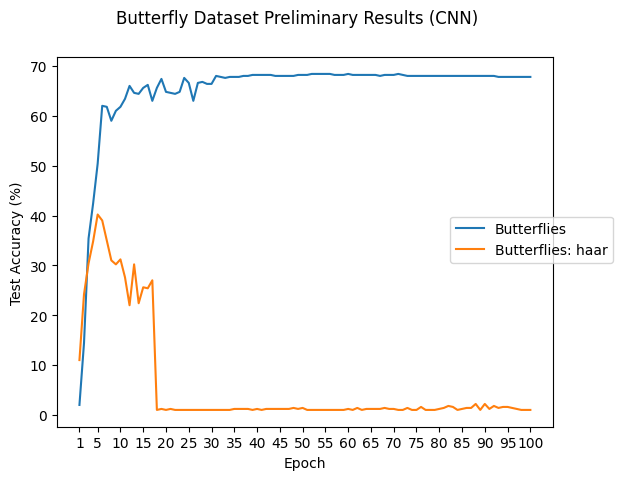

In [28]:
fig, ax = plot_epoch_info("../result/Butterfly_original.txt", ["../result/Butterfly_haar.txt"], "Butterflies", ["haar"])
ax.set_xticks([0] + [5*i - 1 for i in range(1, 21)])
ax.set_ylabel("Test Accuracy (%)")
ax.set_xlabel("Epoch")
fig.suptitle("Butterfly Dataset Preliminary Results (CNN)")
plt.show()